In [314]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [315]:
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [316]:
data = np.load("rps_data.npy")
labels = np.load("rps_labels.npy")
data = data[:len(data)-(len(data) % 25)]
shuffler = np.random.permutation(len(data))
data = data[shuffler]
labels = labels[shuffler]
trainingData = data[:len(data)-50, :]
testData = data[len(data)-50:, :]
trainingLabels = labels[:len(data)-50]
testLabels = labels[len(data)-50:]
print(trainingData.shape)
print(testData.shape)


(575, 6)
(50, 6)


In [317]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.LSTM = nn.LSTM(1, 1800, batch_first=True, num_layers=1)
        self.FC1 = nn.Linear(1800, 3600)
        self.FC2 = nn.Linear(3600, 3)
        self.dropout = nn.Dropout()
        

    def forward(self, x):
        lstmOutput, _ = self.LSTM(x)
        x = F.relu(self.FC1(lstmOutput[:, -1, :]))
        x = self.dropout(x)
        x = self.FC2(x)
        x = F.softmax(x)
        return x

net = Net().to(device)
print(net)

Net(
  (LSTM): LSTM(1, 1800, batch_first=True)
  (FC1): Linear(in_features=1800, out_features=3600, bias=True)
  (FC2): Linear(in_features=3600, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [318]:
def train(data, labels, net: nn.Module):
    lossFunction = nn.CrossEntropyLoss()
    lossList = []
    accuracyList = []
    epochs = 10
    batchSize = 100
    optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
    optimizer.zero_grad()

    for _ in tqdm(range(epochs)):
        for batchNumber in range(int(len(data) / batchSize)):
            start = batchNumber * batchSize
            currentData = data[start:start+batchSize, :, :]
            currentLabels = labels[start:start+batchSize]
            
            inputData = torch.FloatTensor(currentData).to(device)
            inputData.requires_grad_()
            outputData = torch.LongTensor(currentLabels).to(device)
            currentPredictions = net(inputData)

            currentLoss = lossFunction(currentPredictions, outputData)

            currentLoss.backward()

            optimizer.step()

            optimizer.zero_grad()

            lossList.append(currentLoss.item())

            accuracyList.append((currentPredictions.argmax(1) == outputData).type(torch.float).sum().item() / batchSize)
    
    return lossList, accuracyList

In [319]:
def test(testData, testLabels, net):
    net.eval()
    batchSize = 25
    correct = 0
    with torch.no_grad():
        for batchNumber in range(int(len(testData) / batchSize)):
            start = batchNumber * batchSize

            currentData = testData[start:start+batchSize, :]

            currentData = torch.FloatTensor(currentData).to(device)

            currentLabels = testLabels[start:start+batchSize]
            currentLabels = torch.LongTensor(currentLabels).to(device)
            
            prediction = net(currentData)

            correct += (prediction.argmax(1) == currentLabels).type(torch.float).sum().item()
    return correct / len(testLabels)

In [320]:
actualTest = np.array(testData)

In [321]:
actualData = np.array(trainingData)
actualData = actualData.reshape(actualData.shape[0], actualData.shape[1], 1)
print(actualData.shape)

(575, 6, 1)


In [322]:
lossList, accList = train(actualData, np.array(trainingLabels), net)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/m2/vd7bhy010wv4jcz0_pttj9l40000gn/T/ipykernel_95243/2060525376.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


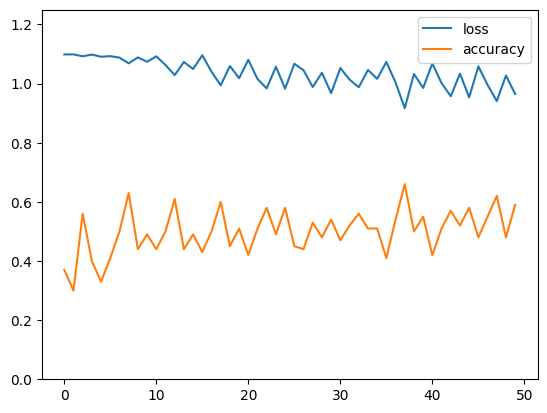

In [323]:
plt.plot(range(len(lossList)), lossList, range(len(accList)), accList)
plt.legend(['loss', 'accuracy'])
plt.ylim((0,1.25))
plt.show()

In [324]:
print("Accuracy:", str(test(actualTest.reshape(actualTest.shape[0], actualTest.shape[1], 1), np.array(testLabels), net)))

Accuracy: 0.62


/var/folders/m2/vd7bhy010wv4jcz0_pttj9l40000gn/T/ipykernel_95243/2060525376.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [325]:
net.eval()
t = np.array([[0, 1, 2, 1, 2, 0, 1]]).reshape(1,7,1)
print(net(torch.FloatTensor(t)).argmax(1))

tensor([0])


/var/folders/m2/vd7bhy010wv4jcz0_pttj9l40000gn/T/ipykernel_95243/2060525376.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [326]:
net_script = torch.jit.script(net)
net_script.save("rps_game_ai.pt")

In [327]:
new_data = np.load("rps_data.npy")
new_labels = np.load("rps_labels.npy")
print(new_data.shape)
print(new_labels.shape)

(643, 6)
(643,)
